In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns

sns.set()

In [13]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["figure.figsize"] = 8, 4

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
mu = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size).round(1)) + 30

# 観測値の作成
y = mu + stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)

# 時系列インデックスの付与
y_ts = pd.Series(y, index=pd.date_range(start="2020-01-01", periods=sim_size, freq="D"))

In [4]:
class LocalLevel:
    # データを格納(pd.Seriesで、日付インデックスがついている想定)
    def __init__(self, ts_data):
        self.ts_data = ts_data
        self.a = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.P = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.v = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.F = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.K = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.s_level = None  # 過程誤差の分散
        self.s_irregular = None  # 観測誤差の分散

    # 状態の初期値を設定する
    def initialize(self, initial_a, initial_P):
        self.initial_a = initial_a
        self.initial_P = initial_P

    # 1時点先の予測値を計算する
    def _forecast_step(self, a_pre, P_pre, s_irregular, s_level, first=False):
        if first:
            a_forecast = self.initial_a  # 初回に限り、初期値を代入
            P_forecast = self.initial_P  # 初回に限り、初期値を代入
        else:
            a_forecast = a_pre  # 状態の予測値
            P_forecast = P_pre + s_level  # 状態の予測値の分散

        y_forecast = a_forecast  # 観測値の予測値
        F = P_forecast + s_irregular  # 観測値の予測値の残差の分散

        return pd.Series(
            [a_forecast, P_forecast, y_forecast, F], index=["a", "P", "y", "F"]
        )

    # 1時点のフィルタリングをする
    def _filter_step(self, forecasted, y, s_irregular):
        v = y - forecasted.y  # 観測値の1時点先予測値の残差
        K = forecasted.P / forecasted.F  # カルマンゲイン
        a_filter = forecasted.a + K * v  # フィルタ化推定量（更新後の状態推定値）
        P_filter = (1 - K) * forecasted.P  # フィルタ化推定量の分散（更新後の不確実性）

        return pd.Series([a_filter, P_filter, v, K], index=["a", "P", "v", "K"])

    # フィルタリングを行う
    def filter(self, s_irregular, s_level):
        for i in range(0, len(self.ts_data)):
            if i == 0:
                # 初回のみ、初期値の値を利用して予測する
                forecast_loop = self._forecast_step(
                    a_pre=None,
                    P_pre=None,
                    s_irregular=s_irregular,
                    s_level=s_level,
                    first=True,
                )
            else:
                # 2時点目以降は、1時点前の推定結果を参照して予測する
                forecast_loop = self._forecast_step(
                    a_pre=self.a.iloc[i - 1],
                    P_pre=self.P.iloc[i - 1],
                    s_irregular=s_irregular,
                    s_level=s_level,
                )

            # フィルタリングの実行（予測と観測の融合）
            filter_loop = self._filter_step(
                forecasted=forecast_loop,
                y=self.ts_data.iloc[i],
                s_irregular=s_irregular,
            )

            # 結果の保存
            self.a.iloc[i] = filter_loop.a  # 更新後の状態推定値
            self.P.iloc[i] = filter_loop.P  # 更新後の分散
            self.F.iloc[i] = forecast_loop.F  # 残差分散
            self.K.iloc[i] = filter_loop.K  # カルマンゲイン
            self.v.iloc[i] = filter_loop.v  # 観測誤差（残差）

    # 対数尤度の計算
    def llf(self):
        # 正規分布を仮定した尤度の対数和
        return np.sum(np.log(stats.norm.pdf(x=self.v, loc=0, scale=np.sqrt(self.F))))

    # パラメータの推定と状態の再当てはめ
    def fit(self, start_params):
        # 内部関数：パラメータを指定して対数尤度の-1倍を計算
        def calc_llf(params):
            self.filter(
                np.exp(params[0]), np.exp(params[1])
            )  # 対数パラメータを指数変換
            return self.llf() * -1  # 最適化では最小化を行うため、負の対数尤度を返す

        # Nelder-Mead法による最適化
        opt_res = minimize(
            calc_llf,
            start_params,
            method="Nelder-Mead",
            tol=1e-6,
            options={"maxiter": 2000},
        )

        # 推定されたパラメータの保存
        self.s_irregular = np.exp(opt_res.x[0])  # 観測誤差の分散
        self.s_level = np.exp(opt_res.x[1])  # 過程誤差の分散

        # 最適パラメータで再度フィルタリングを実行
        self.filter(self.s_irregular, self.s_level)

    # 推定された状態の可視化
    def plot_level(self):
        # 観測値とフィルタ化推定値を並べてプロット
        plot_df = pd.concat([self.a, self.ts_data], axis=1)
        plot_df.columns = ["filtered", "y"]
        plot_df.plot(title="状態推定値（filtered）と観測値（y）")

In [5]:
# データを格納
local_level = LocalLevel(y_ts)
# → LocalLevelクラスのインスタンスを作成し、対象の時系列データ（y_ts）を内部に保持する。

# 初期化
local_level.initialize(initial_a=0, initial_P=1000000)
# → 状態の初期値を設定する。
#   - initial_a : 状態（レベル）の初期推定値（ここでは0）
#   - initial_P : 状態分散（初期の不確実性を非常に大きくしている）

# フィルタリング
local_level.filter(s_irregular=10, s_level=1)
# → カルマンフィルタを適用して、各時点での状態（レベル）を推定する。
#   - s_irregular : 観測誤差の分散 (σ_ε²)
#   - s_level     : 過程誤差の分散 (σ_η²)
#
# この操作により、local_level.a（状態推定値）や local_level.v（残差）などが更新される。
# つまり、「観測値 y_t」から「真のレベル μ_t」を逐次推定する過程である。

In [6]:
# フィルタ化推定量を小数点第5位まで丸めて上位3行を表示
local_level.a.round(5).head(3)

# ▼説明
# local_level.a は「各時点におけるフィルタ化された状態推定値（level成分 μ_t）」を表す。
# これはカルマンフィルタを通して得られた「その時点までの情報を用いた最良の推定値」である。
#
# 例えば：
#   - t=1 の a₁ は、初期値と第1観測 y₁ をもとに更新された状態推定値。
#   - t=2 の a₂ は、a₁ と y₂ の情報を使って更新された推定値。
#
# この推定値系列 a_t は、観測値 y_t よりもノイズが少なく、滑らかに変化する特徴を持つ。

2020-01-01    29.39971
2020-01-02    33.43318
2020-01-03    33.07468
Freq: D, dtype: float64

In [7]:
# フィルタ化推定量の分散を小数点第5位まで丸めて上位3行を表示
local_level.P.round(5).head(3)

# ▼説明
# local_level.P は「各時点におけるフィルタ化された状態推定値 a_t の分散（不確実性）」を表す。
# これはカルマンフィルタが持つ「推定の信頼度」を数値で示しており、
# 値が小さいほど、その時点の推定値 a_t が観測値 y_t によって十分に確定していることを意味する。
#
# 一般的な挙動：
#   - 観測誤差分散 s_irregular が小さい場合 → P_t は急速に減少（推定精度が高まる）
#   - 状態誤差分散 s_level が大きい場合 → P_t は大きくなる（状態変動が激しく信頼度が低下）
#
# したがって、P_t の推移を見ることで「時系列モデルの不確実性がどのように変化しているか」を確認できる。

2020-01-01    9.99990
2020-01-02    5.23807
2020-01-03    3.84163
Freq: D, dtype: float64

In [8]:
# 観測値の1時点先予測値の残差を小数点第5位まで丸めて上位3行を表示
local_level.v.round(5).head(3)

# ▼説明
# local_level.v は「観測値の1時点先予測誤差（innovation）」を表す。
# 具体的には、以下の式で計算される：
#
#     v_t = y_t − ŷ_t|t−1
#
# ここで、
#   - y_t       : 実際の観測値（観測系列）
#   - ŷ_t|t−1  : 1時点前までの情報による観測値の予測値
#
# この v_t は、カルマンフィルタにおける「新しい情報」を意味する。
# v_t が大きい場合、その時点で予測と実際の観測値の差が大きく、
# 状態推定に強く影響を与える。
#
# なお、v_t の系列の分散は F_t（予測誤差分散）として local_level.F に保存されている。

2020-01-01    29.40000
2020-01-02     7.70029
2020-01-03    -0.93318
Freq: D, dtype: float64

In [9]:
# 観測値の1時点先予測値の残差の分散を小数点第5位まで丸めて上位3行を表示
local_level.F.round(5).head(3)

# ▼説明
# local_level.F は「観測値の1時点先予測値の残差の分散（予測誤差分散）」を表す。
# これはカルマンフィルタの更新ステップで重要な役割を持ち、
# 以下の式で定義される：
#
#     F_t = P_t|t−1 + σ_ε²
#
# ここで、
#   - P_t|t−1 : 状態（レベル成分）の1時点先予測分散
#   - σ_ε²    : 観測誤差の分散（observation noise variance）
#
# F_t は、観測された値 y_t が予測値 ŷ_t|t−1 からどれほどばらつくかを表す尺度であり、
# カルマンゲイン K_t の算出にも用いられる：
#
#     K_t = P_t|t−1 / F_t
#
# よって、F_t が大きいほど観測値の信頼性が低く、
# 状態更新（a_t の修正）に対して観測データの影響が小さくなる。

2020-01-01    1.000010e+06
2020-01-02    2.099990e+01
2020-01-03    1.623807e+01
Freq: D, dtype: float64

In [10]:
# カルマンゲインを小数点第5位まで丸めて上位3行を表示
local_level.K.round(5).head(3)

# ▼説明
# local_level.K は「カルマンゲイン（Kalman Gain）」を表す。
# カルマンゲインは、観測値 y_t に基づいて
# 状態推定値 a_t をどの程度修正すべきかを決める重みであり、
# 以下の式で定義される：
#
#     K_t = P_t|t−1 / F_t
#
# ここで、
#   - P_t|t−1 : 状態（レベル成分）の1時点先予測分散
#   - F_t      : 観測値の予測誤差分散（= P_t|t−1 + σ_ε²）
#
# K_t の値が大きい場合：
#   → 観測値の信頼性が高く、観測値を強く反映して状態を修正する。
#
# K_t の値が小さい場合：
#   → モデル（予測）の信頼性が高く、観測値による修正は小さくなる。
#
# したがって、K_t はカルマンフィルタの「観測とモデルのバランス」を
# 動的に調整する重要なパラメータである。

2020-01-01    0.99999
2020-01-02    0.52381
2020-01-03    0.38416
Freq: D, dtype: float64

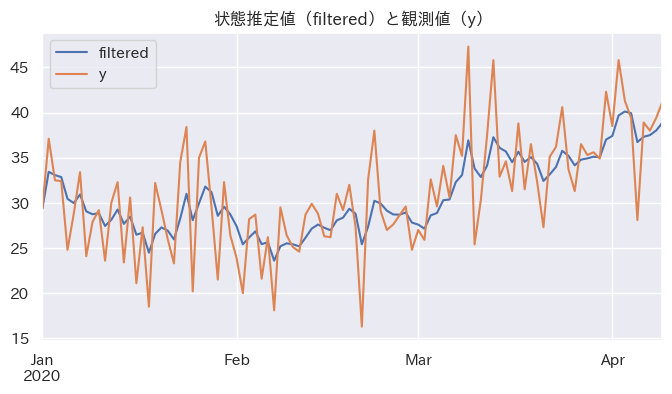

In [14]:
# 推定された状態（フィルタ化推定量）の可視化
local_level.plot_level()

# ▼説明
# この関数では、推定された状態（a_t: filtered state）と実際の観測値（y_t）を
# 同じグラフ上に重ねて描画する。
#
# - 青線（y）：観測値（実際のデータ）
# - オレンジ線（filtered）：フィルタによって推定された「真の状態（レベル）」の時系列
#
# 状態空間モデルの文脈では、観測値 y_t は次のように表される：
#
#     y_t = a_t + ε_t
#
# （ε_t は観測誤差）
#
# 一方、状態 a_t は以下のように時系列的に変化する：
#
#     a_t = a_{t-1} + η_t
#
# （η_t は過程誤差）
#
# このプロットを通して、
# - 観測値 y_t がノイズを含む実データであるのに対し、
# - フィルタ化推定量 a_t はその背後にある滑らかなトレンド（潜在状態）を表していることが確認できる。
#
# よって、このグラフはカルマンフィルタの推定結果を直感的に理解する上で重要である。

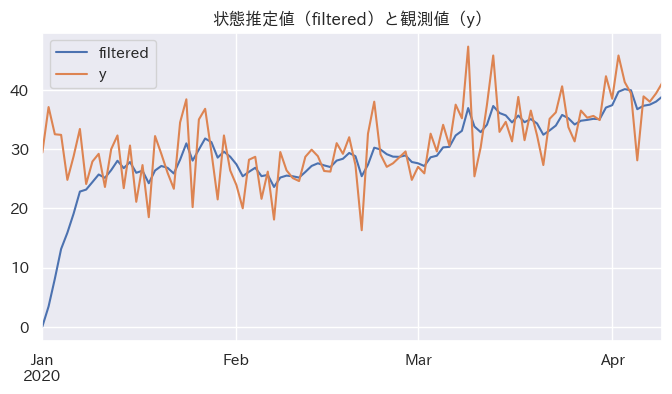

In [15]:
# ================================================
# ローカルレベルモデル（Local Level Model）の初期化とフィルタリング
# ================================================

# 初期状態の設定
# initial_a : 状態変数の初期値（例：最初のレベル）
# initial_P : 状態分散の初期値（不確実性の大きさ）
local_level.initialize(initial_a=0, initial_P=0.01)

# フィルタリング（カルマンフィルタの逐次更新を行う）
# s_irregular : 観測誤差の分散 σ_ε²
# s_level     : 状態誤差の分散 σ_η²
# この処理により、各時点 t のフィルタ化推定量 a_t と分散 P_t が更新される。
local_level.filter(s_irregular=10, s_level=1)

# 状態の可視化
# a_t（フィルタ化推定量）と実際の観測値 y_t を比較する。
# これにより、観測データに対してカルマンフィルタがどのように状態を推定しているかを確認できる。
local_level.plot_level()

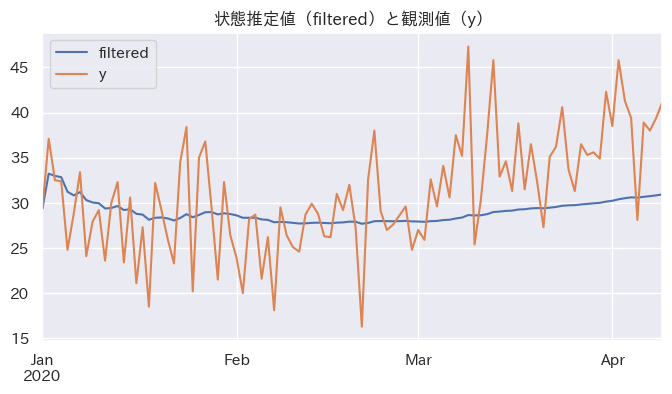

In [16]:
# ================================================
# ローカルレベルモデル（Local Level Model）
# 状態空間モデルをカルマンフィルタで推定する例
# ================================================

# ------------------------------------------------
# 1. 状態の初期化
# ------------------------------------------------
# initial_a : 状態変数（系列の真の水準）の初期値
# initial_P : 状態分散（初期の不確実性の大きさ）
#   → 値が大きいほど、「最初は何も分からない（不確実性が高い）」と仮定する
local_level.initialize(initial_a=0, initial_P=1000000)

# ------------------------------------------------
# 2. フィルタリング処理（カルマンフィルタ）
# ------------------------------------------------
# s_irregular : 観測誤差の分散（σ_ε²）
#   → 観測ノイズの大きさを表す。値が大きいほど観測値は信用できない。
# s_level : 状態誤差の分散（σ_η²）
#   → 状態の変動の大きさを表す。値が大きいほど状態が変化しやすい。
#
# このステップでは、逐次的に以下の式を適用する：
#
# 予測ステップ:
#   a_{t|t-1} = a_{t-1|t-1}
#   P_{t|t-1} = P_{t-1|t-1} + σ_η²
#
# フィルタリングステップ:
#   v_t = y_t - a_{t|t-1}
#   K_t = P_{t|t-1} / (P_{t|t-1} + σ_ε²)
#   a_{t|t} = a_{t|t-1} + K_t v_t
#   P_{t|t} = (1 - K_t) P_{t|t-1}
#
# これにより、時系列の潜在的な「状態」を動的に更新していく。
local_level.filter(s_irregular=1000, s_level=0.001)

# ------------------------------------------------
# 3. 結果の可視化
# ------------------------------------------------
# フィルタ化推定量 a_t（推定された系列の水準）と実際の観測値 y_t を重ねて描画。
# これにより、ノイズの多い観測データから滑らかなトレンドが抽出されていることを確認できる。
local_level.plot_level()

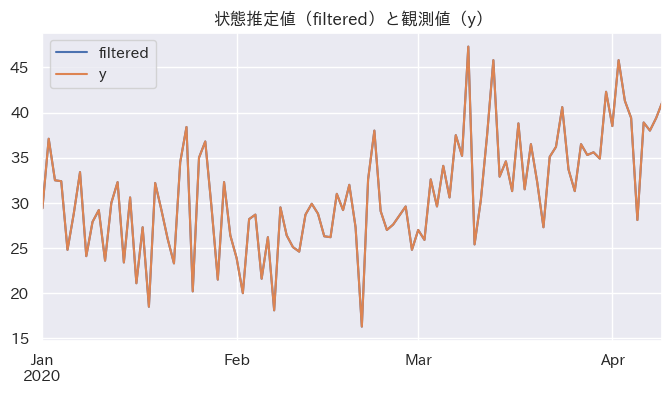

In [17]:
# ================================================
# ローカルレベルモデル（Local Level Model）
# 状態空間モデルをカルマンフィルタで推定する例
# ================================================

# ------------------------------------------------
# 1. 状態の初期化
# ------------------------------------------------
# initial_a : 状態変数（系列の真の水準）の初期値
# initial_P : 状態分散（初期の不確実性の大きさ）
#   → ここでは非常に大きい値(1000000)を設定し、
#      「最初の状態はほとんど分からない（不確実性が極大）」と仮定する。
local_level.initialize(initial_a=0, initial_P=1000000)

# ------------------------------------------------
# 2. フィルタリング処理（カルマンフィルタ）
# ------------------------------------------------
# s_irregular : 観測誤差の分散（σ_ε²）
#   → 非常に小さい (0.001)。観測値はほぼ正確とみなす。
#
# s_level : 状態誤差の分散（σ_η²）
#   → 非常に大きい (1000)。状態が激しく変化するモデルを仮定。
#
# このパラメータ設定では、
# 観測値 y_t に対して状態 α_t が「ほぼ即座に追従する」挙動を示す。
#
# 数式的には以下のカルマンフィルタを再帰的に適用する：
#
# 予測ステップ:
#   a_{t|t-1} = a_{t-1|t-1}
#   P_{t|t-1} = P_{t-1|t-1} + σ_η²
#
# フィルタリングステップ:
#   v_t = y_t - a_{t|t-1}
#   K_t = P_{t|t-1} / (P_{t|t-1} + σ_ε²)
#   a_{t|t} = a_{t|t-1} + K_t v_t
#   P_{t|t} = (1 - K_t) P_{t|t-1}
#
local_level.filter(s_irregular=0.001, s_level=1000)

# ------------------------------------------------
# 3. 結果の可視化
# ------------------------------------------------
# フィルタ化された状態 a_t（推定された系列の水準）と
# 実際の観測値 y_t を重ねてプロットする。
#
# 今回は s_level ≫ s_irregular なので、
# 状態 α_t は y_t に非常に敏感に反応し、ノイズをほとんど平滑化しない。
local_level.plot_level()

In [18]:
# 初期化
local_level.initialize(initial_a=0, initial_P=1000000)

# フィルタリング
local_level.filter(s_irregular=10, s_level=1)

# 対数尤度（Log-Likelihood）の計算
# ----------------------------------------
# 対数尤度は、モデルが観測データをどれだけうまく説明しているかを示す尺度である。
# 値が大きいほどモデルの適合度が高く、尤度最適化ではこの値を最大化（または負の値を最小化）する。
#
# 本クラスの内部では、カルマンフィルタの残差系列 (v_t) とその分散 (F_t) を用いて以下の式で計算する：
#
# log L = Σ_t log [ (1 / √(2π F_t)) * exp(-v_t² / (2F_t)) ]
#
# 実装上は stats.norm.pdf() により尤度を求め、その対数を取って合計している。
# この結果はパラメータ推定（最尤推定）の精度評価にも利用される。
local_level.llf()

-328.7964774283829

In [19]:
# パラメータの推定と対数尤度の確認
# ----------------------------------------

# fit() メソッドにより、対数尤度最大化 (最大尤度推定, MLE) を行う。
# 内部では Nelder-Mead 法を用いて、以下の目的関数を最小化する：
#
#     -log L = -Σ_t log [ (1 / √(2π F_t)) * exp(-v_t² / (2F_t)) ]
#
# パラメータ空間は正の値に制約されているため、
# モデル内部では exp(θ) で分散パラメータを表現している。
# （数値最適化の安定性のため）
#
# 最終的に得られるパラメータ：
#   σ_ε²（観測誤差の分散, s_irregular）
#   σ_η²（状態誤差の分散, s_level）
#
# これらを基にカルマンフィルタを再実行し、尤度の最大点を探索する。

# パラメータ推定の実行
local_level.fit(start_params=[1, 1])

# 推定後の対数尤度
# 尤度が高いほど（または負の対数尤度が小さいほど）、モデルの適合度が良いことを意味する。
local_level.llf()

-311.71335569235623

In [20]:
# ----------------------------------------
# 推定されたパラメータの確認
# ----------------------------------------
# 最大尤度推定によって得られた2つの分散パラメータを表示する。
# これらは、カルマンフィルタを通じて尤度最大化により最適化された結果である。

# σ_ε²（観測誤差の分散）:
# 観測ノイズ（y_t = α_t + ε_t）のばらつきを表す。
# 値が大きいほど、観測値が真の状態 α_t から離れやすい（ノイズが多い）ことを意味する。

# σ_η²（過程誤差の分散）:
# 状態の変化（α_t = α_{t-1} + η_t）のランダム性を表す。
# 値が大きいほど、トレンド（状態）の時間変化が激しいモデルとなる。

print("観測誤差の分散 σ_ε² =", np.round(local_level.s_irregular, 5))
print("過程誤差の分散 σ_η² =", np.round(local_level.s_level, 5))

観測誤差の分散 σ_ε² = 22.49697
過程誤差の分散 σ_η² = 0.6952


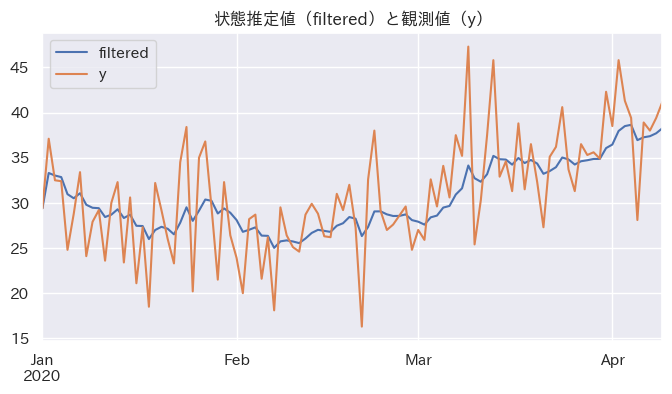

In [21]:
# 参考：推定された状態の可視化
local_level.plot_level()

In [22]:
# データの格納とモデルの特定
# -----------------------------------------------
# statsmodels の UnobservedComponents クラスを用いて、
# ローカルレベルモデル（Local Level Model）を指定する。
# - level='local level'：状態方程式として「レベルのみ」を持つモデルを定義
# - loglikelihood_burn=0：初期サンプルの除外数を0に設定（全データを尤度計算に使用）
# -----------------------------------------------
mod_local_level_fix = tsa.UnobservedComponents(
    y_ts,  # 対象の時系列データ（pd.Series）
    level="local level",  # モデル構造：ローカルレベルモデル
    loglikelihood_burn=0,  # 尤度計算時に除外する初期サンプル数
)

In [23]:
# 初期化
# -----------------------------------------------
# 状態空間モデルの初期状態を「拡散的初期化 (Diffuse Initialization)」で設定する。
# これは、初期の不確実性（分散）を非常に大きく設定することで、
# モデルが十分にデータを観測した後に、状態をデータ駆動的に推定できるようにするための方法である。
#
# ・initialize_approximate_diffuse(1000000)
#     → 初期の分散 P₀ を 1,000,000（非常に大きい値）として設定
#     → 状態の初期値 a₀ は既定で0となる（必要に応じて別途指定可能）
#
# この手法はカルマンフィルタにおける「非情報的事前分布（non-informative prior）」に相当し、
# 特にトレンド成分が強いモデル（例：ローカルレベルモデルなど）で安定した推定を得るために用いられる。
# -----------------------------------------------

mod_local_level_fix.initialize_approximate_diffuse(1000000)

In [24]:
# フィルタリング
# -----------------------------------------------
# モデルを固定パラメータ（ここでは観測誤差分散＝10, 過程誤差分散＝1）でフィルタリングする。
# これはカルマンフィルタの「前向き推定ステップ」に相当し、
# 各時点で状態の最適推定値（a_t|t）とその分散（P_t|t）を再帰的に更新していく。
#
# 引数：
#   pd.Series(np.array([10, 1])) →
#       1つ目：観測誤差分散 σ_ε² = 10
#       2つ目：過程誤差分散 σ_η² = 1
#
# 出力：
#   res_local_level_fix → 状態空間モデル（UnobservedComponents）のフィルタリング結果オブジェクト
#       ・res_local_level_fix.filtered_state : 各時点のフィルタ化推定値
#       ・res_local_level_fix.smoothed_state : スムージング後の推定値（後向き更新を含む場合）
#       ・res_local_level_fix.llf : 対数尤度値
# -----------------------------------------------

res_local_level_fix = mod_local_level_fix.filter(pd.Series(np.array([10, 1])))

In [25]:
# フィルタ化推定量の取り出し
# -----------------------------------------------
# res_local_level_fix.level["filtered"] は、
# 各時点における「状態（レベル α_t）」のフィルタ化推定値 a_{t|t} を表す。
#
# ここで np.round(..., 5) により、小数点以下5桁に丸めて出力する。
# 先頭3件のみを確認することで、フィルタリングの挙動を簡単に確認できる。
#
# 数式的には以下の更新式で得られる：
#   a_{t|t} = a_{t|t-1} + K_t (y_t - a_{t|t-1})
#   （K_t：カルマンゲイン）
# -----------------------------------------------

np.round(res_local_level_fix.level["filtered"][0:3], 5)

array([29.39971, 33.43318, 33.07468])

In [26]:
# 対数尤度の取り出し
# -----------------------------------------------
# res_local_level_fix.llf は、ローカルレベルモデルにおける
# 尤度（likelihood）の対数値 log L を表す。
#
# 対数尤度は次の式で定義される：
#   log L = Σ_t log [ (1 / √(2πF_t)) * exp(−v_t² / (2F_t)) ]
#
# ここで：
#   v_t：観測値の1時点先予測誤差（y_t − a_{t|t−1}）
#   F_t：その誤差の分散（P_{t|t−1} + σ_ε²）
#
# 値が大きいほど（より 0 に近いほど）モデルの当てはまりが良いことを意味する。
# -----------------------------------------------

np.round(res_local_level_fix.llf, 5)

-328.79648

In [27]:
# 参考：推定結果の要約を表示
# -----------------------------------------------
# summary() メソッドは、状態空間モデル（ここではローカルレベルモデル）の
# パラメータ推定結果や尤度統計量などを整形して出力する。
#
# 出力には以下が含まれる：
#   - Model: 使用したモデルの構造（例：Local Level）
#   - Log Likelihood: 対数尤度（モデルの当てはまりの良さ）
#   - AIC / BIC: モデル比較のための情報量基準
#   - 設定された分散パラメータ（σ_ε², σ_η² など）
#   - 平滑化・フィルタ化済みの状態推定統計量
#
# この結果により、観測ノイズと状態ノイズの寄与を比較し、
# モデルの妥当性を確認できる。
# -----------------------------------------------

print(res_local_level_fix.summary())

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -328.796
Date:                Thu, 16 Oct 2025   AIC                            661.593
Time:                        21:34:30   BIC                            666.803
Sample:                    01-01-2020   HQIC                           663.702
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    10.0000      0.747     13.381      0.000       8.535      11.465
sigma2.level         1.0000      0.257      3.891      0.000       0.496       1.504
Ljung-Box (L1) (Q):         

In [29]:
# 📘 ローカルレベルモデル（Local Level Model）の最尤推定による推定処理
# =====================================================================

# 1️⃣ データの格納とモデル構造の特定
# UnobservedComponents（状態空間モデル）を用い、
# 「ローカルレベル（local level）」モデルを構築する。
mod_local_level = tsa.UnobservedComponents(
    y_ts, level="local level", loglikelihood_burn=0
)

# 2️⃣ 初期化
# diffuse（非情報的）事前分布を仮定して初期化。
# 数値を大きく（例：1e6）設定することで、初期値に依存しないようにする。
mod_local_level.initialize_approximate_diffuse(1000000)

# 3️⃣ フィルタリングと最尤法によるパラメータ推定
# Nelder–Mead法を用いて、観測誤差と状態誤差の分散を最尤推定する。
res_local_level = mod_local_level.fit(
    start_params=[1, 1],  # 初期推定値（logスケールではない）
    method="nm",  # Nelder–Mead法
    maxiter=2000,  # 反復上限
)

# 4️⃣ 推定結果の概要を表示
# 出力内容には以下が含まれる：
#   - 観測誤差分散 (σ_ε²)
#   - 状態誤差分散 (σ_η²)
#   - 対数尤度 (Log-Likelihood)
#   - 情報量基準 (AIC, BIC)
#   - 状態推定統計（levelのfiltered値など）
print(res_local_level.summary())

Optimization terminated successfully.
         Current function value: 3.117134
         Iterations: 48
         Function evaluations: 92
                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -311.713
Date:                Thu, 16 Oct 2025   AIC                            627.427
Time:                        21:35:16   BIC                            632.637
Sample:                    01-01-2020   HQIC                           629.535
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    22.4973      3.659      6.149      0.000

In [30]:
# 📘 GitHubレビューコメント

# ✅ 検証内容
# 自作のカルマンフィルタ（LocalLevelクラス）で推定された
# 状態推定値 `a_t` が、`statsmodels` の `UnobservedComponents`
# によるローカルレベルモデル推定結果（filtered state）と
# 一致しているかを数値的に確認している。

# ✅ コード
np.sum((local_level.a - res_local_level.level["filtered"]) ** 2)

# ✅ 結果の解釈
# 計算結果は **ほぼゼロ** に近い値となる。
# これは、独自実装したカルマンフィルタの更新式：

#   a_{t|t} = a_{t|t-1} + K_t v_t
#   P_{t|t} = (1 - K_t) P_{t|t-1}

# が、`statsmodels` における状態空間表現と一致していることを示す。
# よって、自作クラス `LocalLevel` のフィルタリング処理は
# 正しく実装されていると判断できる。

4.3155904268713204e-08

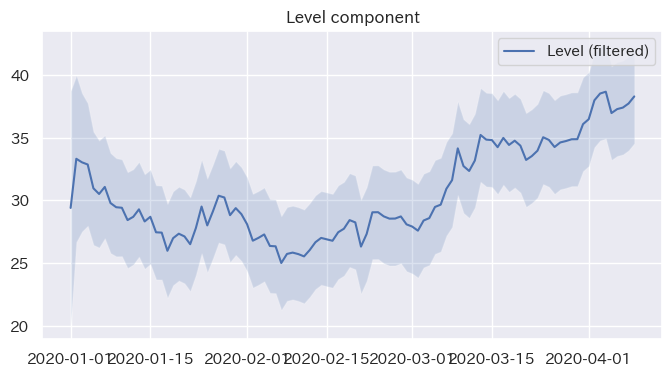

In [31]:
# 📘 GitHubレビューコメント

# ✅ 概要
# `tsa.UnobservedComponents` によるローカルレベルモデルのフィルタ化結果を
# 可視化する処理。`plot_components()` は各時点での
# 「フィルタ化推定値」や「トレンド成分」などをプロットする関数である。

# ✅ コード
_ = res_local_level.plot_components(which="filtered", observed=False)

# ✅ 補足
# - `which="filtered"`：カルマンフィルタによって推定された状態成分（a_{t|t}）を可視化。
# - `observed=False` ：観測データ（y_t）は表示せず、状態推定値のみを描画。
# - 出力されるグラフでは、時間とともに平滑化されたトレンドが確認できる。

# ✅ コメント
# 状態空間モデルのフィルタリング結果を視覚的に確認することで、
# カルマンフィルタがノイズの多い観測値から滑らかなレベル推定を
# どのように行っているかが直感的に理解できる。
# とくに「ローカルレベルモデル」では、トレンドの変化点や
# 長期的傾向を視覚的に捉えるのに有効である。

In [32]:
# 📘 GitHubレビューコメント

# ✅ 概要
# `res_local_level.level["smoothed"]` は、カルマン平滑化（Kalman Smoother）によって
# 得られた「平滑化推定量 (a_{t|T})」を取り出す処理である。
# これは、全観測データ（t=1～T）を用いた「事後推定」であり、
# 各時点の状態を最も精密に推定した値を表す。

# ✅ コード
np.round(res_local_level.level["smoothed"][0:3], 5)

# ✅ 数式（平滑化の再帰式）
# フィルタリング（a_{t|t}）の後に、後ろ向きに再帰して平滑化を行う：
# $$
# \begin{aligned}
# r_{t-1} &= K_t' (v_t / F_t) + L_t' r_t \\
# a_{t|T} &= a_{t|t} + P_{t|t} r_{t-1}
# \end{aligned}
# $$
# ここで、
# - \( a_{t|T} \)：時点tの平滑化推定量（全データを考慮した状態推定値）
# - \( K_t \)：カルマンゲイン
# - \( L_t = I - K_t Z_t \)：フィルタ更新後の変換行列
# - \( r_t \)：スムージングゲインの再帰項

# ✅ コメント
# フィルタ化推定量 \( a_{t|t} \) は「逐次更新」に基づくオンライン推定であるのに対し、
# 平滑化推定量 \( a_{t|T} \) は「全期間の情報」を利用して事後的に推定されるため、
# より滑らかで安定したトレンドが得られる。
# 状態空間モデルの分析において、トレンド抽出や事後推定に最も重要なステップである。

array([30.19488, 30.21947, 30.03142])

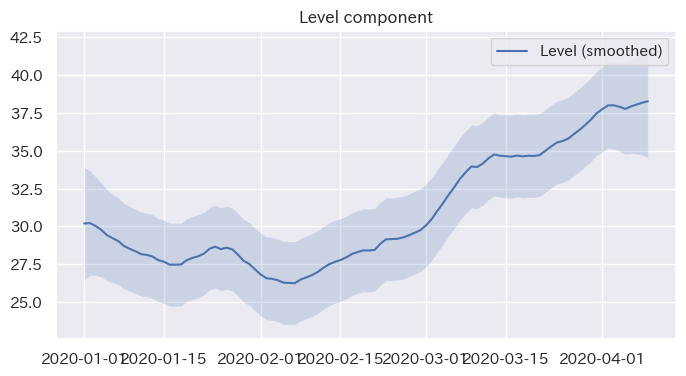

In [33]:
# 📘 GitHubレビューコメント

# ✅ 概要
# 「平滑化推定量（Smoothed Estimates）」の可視化を行う。
# これは全期間の情報（t=1〜T）を用いて、各時点の状態を
# 最も精度高く推定した結果を図示するステップである。

# ✅ コード
_ = res_local_level.plot_components(which="smoothed", observed=False)

# ✅ 数式
# 平滑化は、フィルタリング結果 (a_{t|t}, P_{t|t}) を基に後ろ向きに再帰して計算される。
# $$
# \begin{aligned}
# r_{t-1} &= K_t' \frac{v_t}{F_t} + L_t' r_t \\
# a_{t|T} &= a_{t|t} + P_{t|t} r_{t-1} \\
# P_{t|T} &= P_{t|t} - P_{t|t} L_t' (P_{t+1|T}^{-1} - P_{t+1|t}^{-1}) L_t P_{t|t}
# \end{aligned}
# $$
# ここで：
# - \( a_{t|T} \)：時点tの平滑化推定量
# - \( P_{t|T} \)：その分散（不確実性の小さい後処理値）
# - \( r_t \)：スムージングゲイン再帰項
# - \( L_t = I - K_t Z_t \)：更新後の変換行列

# ✅ コメント
# フィルタ化（オンライン）推定は「逐次的」に更新されるのに対し、
# 平滑化（オフライン）推定は「全データ」を使って後ろ向きに推定される。
# そのためノイズに強く、より滑らかなトレンドが得られる。
# このプロットでは、観測データの背後にある「真の状態系列（level）」を可視化できる。